In [1]:
from torch.utils.data import Dataset, Subset
from random import shuffle
from itertools import combinations
from threading import Lock, Thread
from collections import MutableMapping
import time
import pickle
import zlib
import numpy as np

import garner as g

C:\Users\kipst\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  """


In [2]:
class Segment:
    """
    A short recording of agent's behaviour in the environment,
    consisting of a number of video frames and the rewards it received
    during those frames.
    """

    def __init__(self):
        self.frames = []
        self.rewards = []
        self.hash = None

    def append(self, frame, reward = None):
        self.frames.append(frame)
        self.rewards.append(reward)

    def finalise(self, seg_id=None):
        if seg_id is not None:
            self.hash = seg_id
        else:
            # This looks expensive, but don't worry -
            # it only takes about 0.5 ms.
            self.hash = hash(np.array(self.frames).tobytes())

    def __len__(self):
        return len(self.frames)
    
class CompressedDict(MutableMapping):

    def __init__(self):
        self.store = dict()

    def __getitem__(self, key):
        return pickle.loads(zlib.decompress(self.store[key]))

    def __setitem__(self, key, value):
        self.store[key] = zlib.compress(pickle.dumps(value))

    def __delitem__(self, key):
        del self.store[key]

    def __iter__(self):
        return iter(self.store)

    def __len__(self):
        return len(self.store)

    def __keytransform__(self, key):
        return key
    
class PrefDB(Dataset):
    """
    A circular database of preferences about pairs of segments.
    For each preference, we store the preference itself
    (mu in the paper) and the two segments the preference refers to.
    Segments are stored with deduplication - so that if multiple
    preferences refer to the same segment, the segment is only stored once.
    """

    def __init__(self, maxlen):
        self.segments = CompressedDict()
        self.seg_refs = {}
        self.prefs = []
        self.maxlen = maxlen

    def append(self, s1, s2, pref):
        k1 = hash(np.array(s1).tobytes())
        k2 = hash(np.array(s2).tobytes())

        for k, s in zip([k1, k2], [s1, s2]):
            if k not in self.segments.keys():
                self.segments[k] = s
                self.seg_refs[k] = 1
            else:
                self.seg_refs[k] += 1

        tup = (k1, k2, pref)
        self.prefs.append(tup)

        if len(self.prefs) > self.maxlen:
            self.del_first()

    def del_first(self):
        self.del_pref(0)

    def del_pref(self, n):
        if n >= len(self.prefs):
            raise IndexError("Preference {} doesn't exist".format(n))
        k1, k2, _ = self.prefs[n]
        for k in [k1, k2]:
            if self.seg_refs[k] == 1:
                del self.segments[k]
                del self.seg_refs[k]
            else:
                self.seg_refs[k] -= 1
        del self.prefs[n]

    def __len__(self):
        return len(self.prefs)

In [3]:
class PrefBuffer:
    def __init__(self, garner, db_train, db_val, maxlen = 1000, maxqlen = 3):
        
        self.garner = garner
        self.train_db = db_train
        self.val_db = db_val
        self.val_fraction = self.val_db.maxlen / (self.val_db.maxlen +
                                     self.train_db.maxlen)
        
        self.segments = CompressedDict()
        self.seg_refs = {}
        
        self.tested_pairs = set()
        self.queue = {}
        self.maxlen = maxlen
        self.maxqlen = maxqlen
        self.lock = Lock()
        self.stop_run = False
        
        #returned = garner.get_backlog(limit=maxlen)
        
        #for uuid, val in returned.items():
            
            
            
            #self.lock.acquire(blocking=True)
            
            #if np.random.rand() < self.val_fraction:
            #    self.val_db.append(val[0][0][:,:,:,0:3], val[0][1][:,:,:,0:3], 1 if val[1] else 0)
            #else:
            #    self.train_db.append(val[0][0][:,:,:,0:3], val[0][1][:,:,:,0:3],  1 if val[1] else 0)
                
            #self.lock.release()
            
    #Aquiring old currently not a good idea :/
        
        
    def select_prefs(self):
        segment_idxs = list(range(len(self.segments)))
        shuffle(segment_idxs)
        possible_pairs = combinations(segment_idxs, 2)
        
        keys = list(pref_buffer.segments.keys())
        
        for i1, i2 in possible_pairs: 
            s1, s2 = self.segments[keys[i1]], self.segments[keys[i2]]
            if ((s1.hash, s2.hash) not in self.tested_pairs) and \
               ((s2.hash, s1.hash) not in self.tested_pairs):
                self.tested_pairs.add((s1.hash, s2.hash))
                self.tested_pairs.add((s2.hash, s1.hash))
                return s1.hash, s2.hash
        
        
    def recv_prefs(self):
        result = self.garner.query()
        
        print(result)
        
        if len(result) != 0:
            for key, value in result.items():
                k1, k2 = self.queue[key]
                
                if np.random.rand() < self.val_fraction:
                    self.val_db.append(self.segments[k1].frames, self.segments[k2].frames, 1 if value else 0)
                else:
                    self.train_db.append(self.segments[k1].frames, self.segments[k2].frames, 1 if value else 0)
            del self.queue[key]
            
    def put_prefs(self):
        try:
            while len(self.queue) <= self.maxqlen:
                print('put')
                k1, k2 = self.select_prefs()
                pref_id = self.garner.put([np.array(self.segments[k1].frames), np.array(self.segments[k1].frames)], False)
                self.queue[pref_id] = (k1, k2)
        except:
            print('No prefs to compare')
        
    def run(self):
        while not self.stop_run:
            time.sleep(1)
            self.put_prefs()
            self.recv_prefs()
            
    def start_thread(self):
        self.stop_run = False
        self.garner.connect()
        Thread(target=self.run).start()
        #self.run()
        
    def stop_thread(self):
        self.garner.disconnect()
        self.stop_recv = True
    
    def get_dbs(self):
        self.lock.acquire(blocking=True)
        train_copy = copy.deepcopy(self.train_db)
        val_copy = copy.deepcopy(self.val_db)
        self.lock.release()
        return train_copy, val_copy
    
    def add_segment(self, segment):
        
        k = segment.hash
        
        if k not in self.segments.keys():
            self.segments[k] = seg
            self.seg_refs[k] = 1
        else:
            self.seg_refs[k] += 1
        
        if len(self.prefs) > self.maxlen:
            self.del_first()
            
        #            k1 = hash(np.array(s1).tobytes())
        #k2 = hash(np.array(s2).tobytes())


    def del_first(self):
        self.del_pref(0)

    def del_pref(self, n):
        if n >= len(self.prefs):
            raise IndexError("Preference {} doesn't exist".format(n))
        k1, k2, _ = self.prefs[n]
        for k in [k1, k2]:
            if self.seg_refs[k] == 1:
                del self.segments[k]
                del self.seg_refs[k]
            else:
                self.seg_refs[k] -= 1
        del self.prefs[n]

    def __len__(self):
        return len(self.prefs)

In [4]:
g.login('kipgparker@gmail.com')
g.select_pool('Deep reinforcement learning from human prefrences')


pref_db_train = PrefDB(maxlen=20000)
pref_db_val = PrefDB(maxlen=5000)
pref_buffer = PrefBuffer(garner = g, db_train=pref_db_train,
                 db_val=pref_db_val)

Authenticated


In [5]:
#pref_buffer.start_thread()

import gym
import cv2

env = gym.make("CartPole-v1")

segment = Segment()

observation = env.reset()
for _ in range(100):
    img = env.render(mode='rgb_array') 
    action = env.action_space.sample() # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    segment.append(cv2.resize(img, dsize=(300,200)))
    
    if done:
        segment.finalise()
        pref_buffer.add_segment(segment)
        
        segment = Segment()
        observation = env.reset()
env.close()

#pref_buffer.stop_thread()

AttributeError: 'PrefBuffer' object has no attribute 'prefs'

In [14]:
pref_buffer.queue['7c56d28d-a9a0-4cd1-aae3-d71a96fb95b4'][0]

2292729986103375002

In [10]:
pref_buffer.start_thread()

connected
put
put
put
put
{}
{}
{}
{}
{}
{}
{'42829197-8c2f-4796-b456-9f9c478970eb': [True]}
put
{}
{}
{}
{}
{}


KeyboardInterrupt: 

In [17]:
len(pref_db_train)

In [18]:
pref_db_train.prefs

In [23]:
np.array(pref_db_train.segments[-8823204979868584136]).shape

(21, 200, 300, 3)

In [26]:
#returned = g.get_backlog()
import matplotlib.pyplot as plt

a = []
b = []

for uuid, val in returned.items():

    plt.imshow(val[0][0])
    break
    

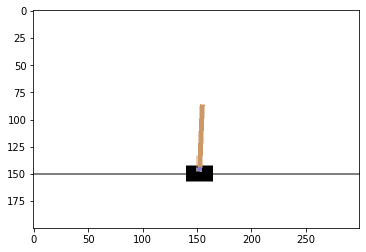

In [27]:
plt.imshow(val[0][0])

In [39]:
list(pref_buffer.segments.keys())[0]

-4014994444739598383

In [12]:
for key, val in b.items():
    

f1f75e89-db70-4302-bdcd-7d028ef5d97d


In [7]:
b = {'f1f75e89-db70-4302-bdcd-7d028ef5d97d': [True]}

{}

In [17]:
gym.close()

AttributeError: module 'gym' has no attribute 'close'

In [16]:
g.put([np.array(segment.frames), np.array(segment.frames)], False)

'a74a6daa-928e-429e-90b4-98771d39c732'

In [17]:
g.storage.download_file('protected/eu-west-2:7cb8b3ea-737d-4479-91b7-103ca54cf28d/77210b95-1dd7-49f6-92f9-23310a80c51a.gif', 'download.gif')

In [ ]:
#out['4cd7869b-0abc-499c-91d0-d36b4a48c004'][0][0][0,:,:,3].shape